In [ ]:
import glob
from skimage.io import imread
from skimage.color import gray2rgb
import pandas as pd, numpy as np

import matplotlib.pyplot as plt


from sklearn import datasets, preprocessing, linear_model, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report

from mlxtend.plotting import plot_confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from zipfile import ZipFile
dataset_path = '/content/drive/MyDrive/CSE428_LAB/Project/Group_2.zip'
dataset_path = '/content/Group_2.zip'

with ZipFile(dataset_path, 'r') as zip:
  zip.extractall()

In [ ]:
def convert_to_csv(path_to_dataset):
    image_paths = glob.glob(path_to_dataset + '/*/*/*.JPEG')

    train_imgs = []
    test_imgs = []

    for image_path in image_paths:
        image = imread(image_path)
        if image.shape[-1] != 3:
            image = gray2rgb(image)
        if image_path.split('/')[-3] == 'train':
            train_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])
        else:
            test_imgs.append(image.ravel().tolist() + [image_path.split('/')[-2]])

    img_0 = imread(image_paths[0])
    column_names = [f"p_{x}" for x in range(np.prod(img_0.shape))] + ['label']

    train_df = pd.DataFrame(train_imgs, columns=column_names)
    test_df = pd.DataFrame(test_imgs, columns=column_names)

    train_df.to_csv(path_to_dataset+'/train.csv', index=False)
    test_df.to_csv(path_to_dataset+'/test.csv', index=False)

convert_to_csv('/content/Group_2')


1.   What is the size of your dataset? Is there a separate batch for train, test, and validation, or do you need to do it manually? What are the different classes in your dataset?

In [ ]:
# What is the size of your dataset?
train_data = pd.read_csv('/content/Group_2/train.csv')
test_data = pd.read_csv('/content/Group_2/test.csv')

print(train_data.shape)
print(test_data.shape)

(2164, 12289)
(250, 12289)


There is a separate batch for train and test but for validation we need to do it manually.

In [ ]:
train_data.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_12279,p_12280,p_12281,p_12282,p_12283,p_12284,p_12285,p_12286,p_12287,label
0,173,76,129,141,44,113,249,151,250,202,...,138,198,51,136,199,46,130,194,38,butterfly
1,10,14,0,9,13,0,9,13,0,7,...,2,4,1,0,2,0,0,1,0,butterfly
2,115,125,36,104,117,25,93,108,13,90,...,107,98,39,113,100,58,117,101,67,butterfly
3,67,61,63,68,62,64,68,62,62,68,...,41,15,0,44,15,0,45,17,0,butterfly
4,4,0,2,10,5,9,3,0,0,1,...,252,255,251,232,236,247,251,254,255,butterfly


In [ ]:
test_data.head()

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_12279,p_12280,p_12281,p_12282,p_12283,p_12284,p_12285,p_12286,p_12287,label
0,216,209,154,189,182,128,209,202,150,227,...,53,83,19,53,87,10,70,106,19,butterfly
1,254,255,253,251,252,246,255,253,241,255,...,255,255,227,255,252,240,252,253,247,butterfly
2,53,82,26,65,94,38,63,92,36,42,...,45,76,19,30,61,4,0,25,0,butterfly
3,65,107,43,70,113,44,68,109,31,68,...,40,81,3,48,85,8,54,91,14,butterfly
4,95,128,41,67,98,18,75,106,38,21,...,19,32,0,63,76,30,69,83,34,butterfly


In [ ]:
train_data.info()
print('')
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Columns: 12289 entries, p_0 to label
dtypes: int64(12288), object(1)
memory usage: 202.9+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Columns: 12289 entries, p_0 to label
dtypes: int64(12288), object(1)
memory usage: 23.4+ MB


In [ ]:
train_label = train_data['label']
test_label = test_data['label']

train_label.unique()
test_label.unique()

array(['butterfly', 'bighorn', 'camel', 'chimpanzee', 'pig'], dtype=object)

2.   What is the distribution of your dataset, i.e., the number of samples per class? Show it using a plot. Is the distribution balanced or unbalanced?

In [ ]:
# Number of samples per class in the training set
train_samples_per_class = train_data['label'].value_counts()

# Number of samples per class in the test set
test_samples_per_class = test_data['label'].value_counts()

# Print the results
print("Number of samples per class in the training set:")
print(train_samples_per_class)

print("\nNumber of samples per class in the test set:")
print(test_samples_per_class)

Number of samples per class in the training set:
butterfly     500
camel         500
chimpanzee    500
bighorn       414
pig           250
Name: label, dtype: int64

Number of samples per class in the test set:
butterfly     50
bighorn       50
camel         50
chimpanzee    50
pig           50
Name: label, dtype: int64


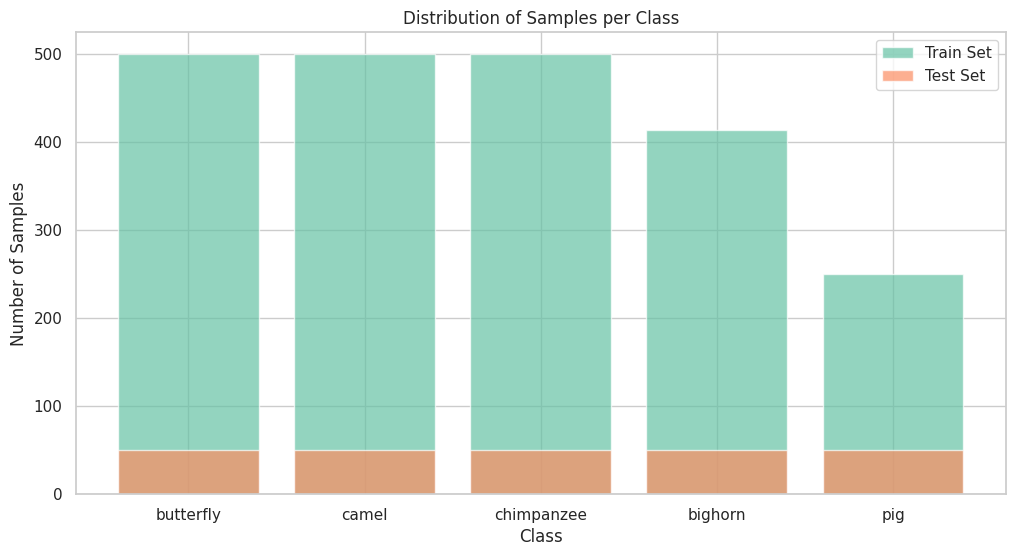

In [ ]:
# Show it using a plot. Is the distribution balanced or unbalanced?
import seaborn as sns

# Set a seaborn style
sns.set(style="whitegrid")

# Define pretty colors
colors = sns.color_palette("Set2")

# Plotting the distribution for training set
plt.figure(figsize=(12, 6))
plt.bar(train_samples_per_class.index, train_samples_per_class.values, color=colors[0], alpha=0.7, label='Train Set')

# Plotting the distribution for test set
plt.bar(test_samples_per_class.index, test_samples_per_class.values, color=colors[1], alpha=0.7, label='Test Set')

plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Distribution of Samples per Class')
plt.legend()
plt.show()

Unbalanced Distribution.

3. Which technique are you going to use to tackle your unbalanced dataset and why? NOTE: you DO NOT need use any such technique for Milestone 1, but you have to use it for the next milestones.

Since 'bighorn' and 'pig' has less data, so we can use SMOTE to upsample the dataset.

In [ ]:
print(train_label)
print(test_label)

0       butterfly
1       butterfly
2       butterfly
3       butterfly
4       butterfly
          ...    
2159          pig
2160          pig
2161          pig
2162          pig
2163          pig
Name: label, Length: 2164, dtype: object
0      butterfly
1      butterfly
2      butterfly
3      butterfly
4      butterfly
         ...    
245          pig
246          pig
247          pig
248          pig
249          pig
Name: label, Length: 250, dtype: object


## Encoding labels

In [ ]:
encode = preprocessing.LabelEncoder()
encode.fit(train_data['label'])
train_data['label'] = encode.transform(train_label)
encode.fit(test_data['label'])
test_data['label'] = encode.transform(test_label)

print(train_data['label'])
print(test_data['label'])

0       1
1       1
2       1
3       1
4       1
       ..
2159    4
2160    4
2161    4
2162    4
2163    4
Name: label, Length: 2164, dtype: int64
0      1
1      1
2      1
3      1
4      1
      ..
245    4
246    4
247    4
248    4
249    4
Name: label, Length: 250, dtype: int64


In [ ]:
x_train = train_data.drop(['label'], axis=1)
y_train = train_data['label']

x_test = test_data.drop(['label'], axis=1)
y_test = test_data['label']

In [ ]:
x_test

,p_0,p_1,p_2,p_3,p_4,p_5,p_6,p_7,p_8,p_9,...,p_12278,p_12279,p_12280,p_12281,p_12282,p_12283,p_12284,p_12285,p_12286,p_12287
0,216,209,154,189,182,128,209,202,150,227,...,50,53,83,19,53,87,10,70,106,19
1,254,255,253,251,252,246,255,253,241,255,...,136,255,255,227,255,252,240,252,253,247
2,53,82,26,65,94,38,63,92,36,42,...,24,45,76,19,30,61,4,0,25,0
3,65,107,43,70,113,44,68,109,31,68,...,7,40,81,3,48,85,8,54,91,14
4,95,128,41,67,98,18,75,106,38,21,...,41,19,32,0,63,76,30,69,83,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,1,0,2,3,3,5,7,7,9,0,...,59,127,95,70,164,129,107,141,106,84
246,0,1,2,5,9,10,6,10,11,0,...,0,1,1,0,1,2,0,1,2,0
247,188,185,150,181,178,143,188,185,150,204,...,101,162,171,128,164,173,130,142,151,108
248,84,70,44,71,57,31,61,47,21,73,...,59,110,83,62,100,73,52,92,65,44


In [ ]:
y_test

0      1
1      1
2      1
3      1
4      1
      ..
245    4
246    4
247    4
248    4
249    4
Name: label, Length: 250, dtype: int64

## Normalization - MinMaxScaler

In [ ]:
x_norm_train = MinMaxScaler().fit_transform(x_train)
x_norm_train = pd.DataFrame(x_norm_train)
x_norm_train

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.678431,0.298039,0.505882,0.552941,0.172549,0.443137,0.976471,0.592157,0.980392,0.792157,...,0.180392,0.541176,0.776471,0.200000,0.533333,0.780392,0.180392,0.509804,0.760784,0.149020
1,0.039216,0.054902,0.000000,0.035294,0.050980,0.000000,0.035294,0.050980,0.000000,0.027451,...,0.011765,0.007843,0.015686,0.003922,0.000000,0.007843,0.000000,0.000000,0.003922,0.000000
2,0.450980,0.490196,0.141176,0.407843,0.458824,0.098039,0.364706,0.423529,0.050980,0.352941,...,0.109804,0.419608,0.384314,0.152941,0.443137,0.392157,0.227451,0.458824,0.396078,0.262745
3,0.262745,0.239216,0.247059,0.266667,0.243137,0.250980,0.266667,0.243137,0.243137,0.266667,...,0.000000,0.160784,0.058824,0.000000,0.172549,0.058824,0.000000,0.176471,0.066667,0.000000
4,0.015686,0.000000,0.007843,0.039216,0.019608,0.035294,0.011765,0.000000,0.000000,0.003922,...,0.909804,0.988235,1.000000,0.984314,0.909804,0.925490,0.968627,0.984314,0.996078,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0.294118,0.227451,0.250980,0.317647,0.250980,0.274510,0.286275,0.219608,0.243137,0.239216,...,0.160784,0.133333,0.098039,0.101961,0.121569,0.086275,0.090196,0.137255,0.101961,0.105882
2160,0.898039,0.898039,0.937255,0.898039,0.898039,0.929412,0.905882,0.901961,0.933333,0.913725,...,0.000000,0.105882,0.254902,0.023529,0.149020,0.305882,0.070588,0.149020,0.305882,0.070588
2161,0.392157,0.372549,0.400000,0.352941,0.333333,0.360784,0.298039,0.278431,0.305882,0.290196,...,0.372549,0.380392,0.360784,0.384314,0.364706,0.345098,0.360784,0.329412,0.309804,0.325490
2162,0.560784,0.498039,0.439216,0.482353,0.419608,0.360784,0.505882,0.439216,0.376471,0.474510,...,0.094118,0.286275,0.243137,0.258824,0.360784,0.317647,0.341176,0.309804,0.270588,0.301961


In [ ]:
print("shape of X =", x_norm_train.shape)
print("shape of y =", y_train.shape)

shape of X = (2164, 12288)
shape of y = (2164,)


In [ ]:
x_norm_test = MinMaxScaler().fit_transform(x_test)
x_norm_test = pd.DataFrame(x_norm_test)
x_norm_test

,0,1,2,3,4,5,6,7,8,9,...,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287
0,0.847059,0.819608,0.603922,0.741176,0.713725,0.501961,0.819608,0.792157,0.588235,0.890196,...,0.196078,0.207843,0.325490,0.074510,0.207843,0.341176,0.039216,0.274510,0.415686,0.074510
1,0.996078,1.000000,0.992157,0.984314,0.988235,0.964706,1.000000,0.992157,0.945098,1.000000,...,0.533333,1.000000,1.000000,0.890196,1.000000,0.988235,0.941176,0.988235,0.992157,0.968627
2,0.207843,0.321569,0.101961,0.254902,0.368627,0.149020,0.247059,0.360784,0.141176,0.164706,...,0.094118,0.176471,0.298039,0.074510,0.117647,0.239216,0.015686,0.000000,0.098039,0.000000
3,0.254902,0.419608,0.168627,0.274510,0.443137,0.172549,0.266667,0.427451,0.121569,0.266667,...,0.027451,0.156863,0.317647,0.011765,0.188235,0.333333,0.031373,0.211765,0.356863,0.054902
4,0.372549,0.501961,0.160784,0.262745,0.384314,0.070588,0.294118,0.415686,0.149020,0.082353,...,0.160784,0.074510,0.125490,0.000000,0.247059,0.298039,0.117647,0.270588,0.325490,0.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.003922,0.000000,0.007843,0.011765,0.011765,0.019608,0.027451,0.027451,0.035294,0.000000,...,0.231373,0.498039,0.372549,0.274510,0.643137,0.505882,0.419608,0.552941,0.415686,0.329412
246,0.000000,0.003922,0.007843,0.019608,0.035294,0.039216,0.023529,0.039216,0.043137,0.000000,...,0.000000,0.003922,0.003922,0.000000,0.003922,0.007843,0.000000,0.003922,0.007843,0.000000
247,0.737255,0.725490,0.588235,0.709804,0.698039,0.560784,0.737255,0.725490,0.588235,0.800000,...,0.396078,0.635294,0.670588,0.501961,0.643137,0.678431,0.509804,0.556863,0.592157,0.423529
248,0.329412,0.274510,0.172549,0.278431,0.223529,0.121569,0.239216,0.184314,0.082353,0.286275,...,0.231373,0.431373,0.325490,0.243137,0.392157,0.286275,0.203922,0.360784,0.254902,0.172549


In [ ]:
print("shape of X =", x_norm_test.shape)
print("shape of y =", y_test.shape)

shape of X = (250, 12288)
shape of y = (250,)


4. Use the logistic regression shown in the last class to classify. Report the following results separately for train and test - accuracy, sensitivity, specificity, positive predictive value (PPV), negative predictive value (NPV), the confusion matrix, and the F1 score. How can we interpret these results?

## Logistic Regression

In [ ]:
# Split the data into training and validation sets (80% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(x_norm_train, y_train, test_size=0.2, random_state=100)

# Print the shapes of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

Training set shape: (1731, 12288) (1731,)
Validation set shape: (433, 12288) (433,)


In [ ]:
alpha_test = [0, 0.01, 0.1, 1, 10, 100, 1000, 10000]
mse_validation_all = {}
for alpha in alpha_test:
    model = linear_model.Ridge(alpha=alpha)
    model = model.fit(X_train, y_train)
    y_pred_valid = model.predict(X_val)
    mse_validation = np.mean((y_pred_valid - y_val)**2)
    mse_validation_all[alpha] = mse_validation
mse_validation_all

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:255: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn(


{0: 2.9529880177823826,
 0.01: 2.9518874672567255,
 0.1: 2.9420648322920426,
 1: 2.8513050838811775,
 10: 2.3404112519319424,
 100: 1.6317204595650163,
 1000: 1.4520827142959003,
 10000: 1.4837124237261299}

In [ ]:
print("X_train shape = ", X_train.shape)
print("X_valid shape = ", X_val.shape)
print("X_test shape = ", x_test.shape)

X_train shape =  (1731, 12288)
X_valid shape =  (433, 12288)
X_test shape =  (250, 12288)


In [ ]:
model = linear_model.LogisticRegression(C=0.001, fit_intercept=True, solver='lbfgs', max_iter=500)
model = model.fit(X_train, y_train)
y_predict = model.predict(X_val)

y_test_predict = model.predict(x_norm_test)

In [ ]:
train_label = train_label.unique()
test_label = test_label.unique()

In [ ]:
def reports(y_test, y_pred, labels):
  accuracy = accuracy_score(y_test, y_pred)
  conf_matrix = confusion_matrix(y_test, y_pred)

  f1 = f1_score(y_test, y_pred, average='weighted')
  sensitivity = recall_score(y_test, y_pred, average=None)
  specificity = []
  for i in range(len(conf_matrix)):
      true_negatives = sum(conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i)
      false_positives = sum(conf_matrix[j][i] for j in range(len(conf_matrix)) if j != i)
      specificity.append(true_negatives / (true_negatives + false_positives))

  ppv = precision_score(y_test, y_pred, average=None)

  for i in range(len(conf_matrix)):
      true_negatives = sum(conf_matrix[j][j] for j in range(len(conf_matrix)) if j != i)
      false_negatives = sum(conf_matrix[i][j] for j in range(len(conf_matrix)) if j != i)
      npv = (true_negatives / (true_negatives + false_negatives))
      print(f'Class {labels[i]} - ',end='')
      print("Sensitivity:", round(sensitivity[i], 5), end=', ')
      print("Specificity:", round(specificity[i], 5), end=', ')
      print("Positive Predictive Value (PPV):", round(ppv[i], 5),end=', ')
      print("Negative Predictive Value (NPV):", round(npv,5))

  print()
  print("Accuracy:", round(accuracy, 5))
  print("Confusion Matrix:")
  print(conf_matrix)
  print("F1 Score:", round(f1, 5))
  print()
  print("Classification metrics:")
  print(metrics.classification_report(y_test, y_pred, digits = 3, target_names = encode.classes_))
  print()


print('\nFor validating:\n')
reports(y_val, y_predict, train_label)
print('\nFor testing:\n')
reports(y_test, y_test_predict, train_label)


For validating:

Class butterfly - Sensitivity: 0.33333, Specificity: 0.89412, Positive Predictive Value (PPV): 0.51786, Negative Predictive Value (NPV): 0.7972
Class bighorn - Sensitivity: 0.83838, Specificity: 0.86139, Positive Predictive Value (PPV): 0.74775, Negative Predictive Value (NPV): 0.91579
Class camel - Sensitivity: 0.64356, Specificity: 0.74131, Positive Predictive Value (PPV): 0.49242, Negative Predictive Value (NPV): 0.84211
Class chimpanzee - Sensitivity: 0.80645, Specificity: 0.78788, Positive Predictive Value (PPV): 0.60484, Negative Predictive Value (NPV): 0.91
Class pig - Sensitivity: 0.09434, Specificity: 0.98054, Positive Predictive Value (PPV): 0.5, Negative Predictive Value (NPV): 0.84

Accuracy: 0.59353
Confusion Matrix:
[[29  7 31 16  4]
 [ 7 83  8  1  0]
 [ 9 12 65 15  0]
 [ 6  3  8 75  1]
 [ 5  6 20 17  5]]
F1 Score: 0.56026

Classification metrics:
              precision    recall  f1-score   support

     bighorn      0.518     0.333     0.406        87

5. Train a five layer (one input layer, one output layer, three hidden layers) neural network using keras with some random number of neurons in the hidden layers on your dataset and use the test dataset to evaluate the model's performance (accuracy, sensitivity, specificity, positive predictive value (PPV), negative predictive value (NPV), the confusion matrix, and the F1 score). Use the logistic activation functions for the hidden layers, and softmax for the output layer. Compare the results with that of the Logistic Regression model.

### Neural Network

In [ ]:
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
import time

#Hyperparameters
validation_split = 0.2
batch_size = 32
img_height = 64
img_width = 64
learning_rate = 1e-3
epochs = 30
train_steps_per_epoch = 68
val_steps_per_epoch = 8

#Directories
train_dir = Path.cwd().parent / "dataset" / "train"
test_dir = Path.cwd().parent / "dataset" / "test"

ds_train = keras.utils.image_dataset_from_directory(
    train_dir,
    labels = "inferred",
    label_mode = "categorical",
    class_names = ["bighorn", "butterfly", "camel", "chimpanzee", "pig"],
    color_mode = "rgb",
    batch_size = batch_size,
    image_size =(img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split = validation_split,
    subset = "training"
)

ds_val = keras.utils.image_dataset_from_directory(
    train_dir,
    labels = "inferred",
    label_mode = "categorical",
    class_names = ["bighorn", "butterfly", "camel", "chimpanzee", "pig"],
    color_mode = "rgb",
    batch_size = batch_size,
    image_size =(img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split=validation_split,
    subset = "validation"
)

ds_test = keras.utils.image_dataset_from_directory(
    test_dir,
    labels = "inferred",
    label_mode = "categorical",
    class_names = ["bighorn", "butterfly", "camel", "chimpanzee", "pig"],
    color_mode = "rgb",
    batch_size = batch_size,
    image_size =(img_height, img_width),
    shuffle = True,
    seed = 123,
    validation_split=validation_split,
    subset = "validation"
)


In [ ]:
class_names = ds_train.class_names

plt.figure(figsize=(10, 10))
for images, labels in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

In [ ]:
def standardize_image(image):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    mean = tf.math.reduce_mean(image)
    std = tf.math.reduce_std(image)
    standardized_image = (image - mean) / std
    return standardized_image

normalization = keras.layers.Rescaling(1./255)

ds_train = ds_train.map(lambda x, y: (standardize_image(x), y))
ds_train = ds_train.map(lambda x, y: (normalization(x), y))

ds_val = ds_val.map(lambda x, y: (standardize_image(x), y))
ds_val = ds_val.map(lambda x, y: (normalization(x), y))

ds_test = ds_test.map(lambda x, y: (standardize_image(x), y))
ds_test = ds_test.map(lambda x, y: (normalization(x), y))

In [ ]:
def define_model(img_height, img_width):
    inputs = tf.keras.Input(shape=(img_height, img_width, 3), name="images")
    flatten = tf.keras.layers.Flatten(input_shape=(img_height, img_width, 3), name="input_layer")(inputs)
    h1 = tf.keras.layers.Dense(256, activation='selu', kernel_initializer="lecun_normal", name="hidden_layer_1")(flatten)
    h2 = tf.keras.layers.Dense(128, activation='selu', kernel_initializer="lecun_normal", name="hidden_layer_2")(h1)
    h3 = tf.keras.layers.Dense(64, activation='selu', kernel_initializer="lecun_normal", name="hidden_layer_3")(h2)
    outputs = tf.keras.layers.Dense(5, name="predictions")(h3)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = define_model(img_height, img_width)
model.summary()

In [ ]:
optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)

train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [ ]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

In [ ]:
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

In [ ]:
for epoch in range(epochs):
    print(f"Start of Epoch {epoch}")
    start_time = time.time()

    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(ds_train):
        loss_value = train_step(x_batch_train, y_batch_train)

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))

    # Display metrics at the end of each epoch.
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))

    # Reset training metrics at the end of each epoch
    train_acc_metric.reset_states()

    # Run a validation loop at the end of each epoch.
    for x_batch_val, y_batch_val in ds_val:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))